In [1]:
#@title Imports

import inspect
import numpy as np
import os
import pickle
import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch
import torchvision
import torch.multiprocessing as mpl
import torch.nn as nn
from torch.utils.data import DataLoader

from functools import wraps
from itertools import repeat
from pathlib import Path
from typing import Tuple, Union, Sequence, Iterable, List

In [2]:
#@title Paths

if os.path.exists("drive/MyDrive"):
    DATA_PATH = Path("drive/MyDrive/data")
else:
    DATA_PATH = Path("data")

if not DATA_PATH.exists():
    DATA_PATH.mkdir(parents=False)

print(f"Data path: {DATA_PATH.absolute()}")

Data path: /Users/mhonsel/Library/CloudStorage/GoogleDrive-mhonsel@googlemail.com/My Drive/data


In [52]:
#@title Helper functions

def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__}{args} {kwargs} Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

In [4]:
#@title Data loaders


DATAPATH = ""
if os.path.exists("drive/MyDrive/data"):
    DATAPATH = "drive/MyDrive/data/"


def get_train_data(bs: int = 64) -> Tuple[DataLoader, DataLoader]:
    """
    Loads training data form default directory given by global variable PATH.
    :param bs: int = batchsize
    :return: Tuple[torch.Dataloader, torch.Dataloader] = Dataloader for training and testing
    """
    trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Lambda(lambda x: torch.flatten(x))])
    train_data = torchvision.datasets.MNIST(DATA_PATH, train=True, download=True, transform=trans)
    test_data = torchvision.datasets.MNIST(DATA_PATH, train=False, transform=trans, download=True)
    return DataLoader(train_data, batch_size=bs, shuffle=True), DataLoader(test_data, batch_size=bs, shuffle=True)


def get_train_data_cifar(bs: int = 64) -> Tuple[DataLoader, DataLoader]:
    """
    Loads training data form default directory given by global variable PATH.
    :param bs: int = batchsize
    :return: Tuple[torch.Dataloader, torch.Dataloader] = Dataloader for training and testing
    """
    trans = torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Lambda(lambda x: torch.flatten(x))])
    train_data = torchvision.datasets.CIFAR10(DATA_PATH / "CIFAR10", train=True, download=True, transform=trans)
    test_data = torchvision.datasets.CIFAR10(DATA_PATH / "CIFAR10", train=False, transform=trans, download=True)
    return DataLoader(train_data, batch_size=bs, shuffle=True), DataLoader(test_data, batch_size=bs, shuffle=True)

In [8]:
train, test = get_train_data(bs=5)
X, y = next(iter(train))
print(X.shape)
print(y.shape)

torch.Size([5, 784])
torch.Size([5])


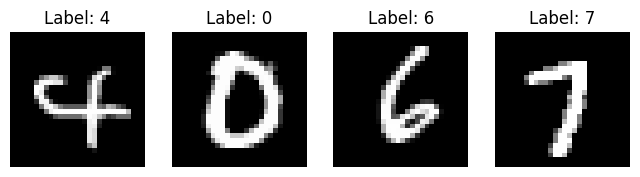

Files already downloaded and verified
Files already downloaded and verified


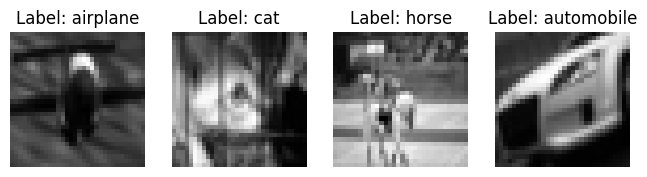

In [7]:
#@title Example data

cols, rows = 4, 1


# MNIST data
train, test = get_train_data(bs=cols*rows)
features, labels = next(iter(train))

mnist_fig = plt.figure(figsize=(8, 8))

for i in range(len(features)):
    mnist_fig.add_subplot(rows, cols, i+1)
    plt.title("Label: {}".format(labels[i]))
    plt.axis("off")
    plt.imshow(features[i].reshape(28, 28), cmap="gray")

plt.show()

# CIFAR10 data
cifar10_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

train, test = get_train_data_cifar(bs=cols*rows)
features, labels = next(iter(train))

cifar10_fig = plt.figure(figsize=(8, 8))

for i in range(len(features)):
    cifar10_fig.add_subplot(rows, cols, i+1)
    plt.title("Label: {}".format(cifar10_labels[labels[i]]))
    plt.axis("off")
    plt.imshow(features[i].reshape(32, 32), cmap="gray")

plt.show()

In [5]:
#@title Worker functions

def worker(c: torch.nn.Sequential, opt: torch.optim.Optimizer, train_data: Tuple[Tuple[torch.tensor, torch.tensor]],
           its: int):
    for _ in range(its):
        for inp, out in train_data:
            loss = torch.nn.functional.mse_loss(c(inp), out)
            loss.backward()
            opt.step()
            opt.zero_grad()


def queue_worker(q):
    while True:
        args = q.get()
        if args == "DONE":
            break

        c, opt, train_data, its = args
        for _ in range(its):
            for inp, out in train_data:
                loss = torch.nn.functional.mse_loss(c(inp), out)
                loss.backward()
                opt.step()
                opt.zero_grad()

In [6]:
#@title Network class

class Network:
    """
    Default network-class
    Resembles a classical discriminator network with either softmax or sigmoid output (no multi-label)
    """

    def __init__(self, input_dim: int, output_dim: int, depth: int, variances: Tuple[float, float], lr: float = 1e-3,
                 device: Union[str, torch.device] = "cpu", size: Union[Sequence, str] = "wide"):
        """
        Initialize a new network with given parameters
        :param input_dim: int = size of the input layer
        :param output_dim: int = size of the output layer
        :param depth: int = depth of neural network (number of hidden layers)
        :param variances: [float, float] = [weight-variance, bias-variance] for initialization of free parameters
        :param lr: float = learning rate for training
        :param device: Union[str, torch.device] = Device to train on
        :param size: Union[Sequence, str] = either "wide", "shrinking" or a sequence of layer sizes
        If sequence is provided, depth will be ignored
        """
        self.lr = lr
        self.device = device
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.depth = depth
        self.variances = variances

        layers = []
        if size == "wide":
            self.sizes = [input_dim] * (depth - 1) + [400, output_dim]
        elif size == "shrinking":
            self.sizes = [int(e) for e in torch.ceil(torch.linspace(input_dim, output_dim, depth))]
        elif isinstance(size, (list, tuple)):
            self.sizes = size
        else:
            raise AttributeError(f"Can not handle size {size}")

        for i in range(len(self.sizes) - 1):
            lin_layer = torch.nn.Linear(self.sizes[i], self.sizes[i + 1])
            torch.nn.init.normal_(lin_layer.weight, mean=0.0, std=(np.sqrt(variances[0] / lin_layer.in_features)))
            torch.nn.init.normal_(lin_layer.bias, mean=0.0, std=(np.sqrt(variances[1])))

            layers.append(lin_layer)
            layers.append(nn.Tanh())

        if self.sizes[-1] == 1:
            layers.append(torch.nn.Sigmoid())
        else:
            layers.append(torch.nn.Softmax(dim=1))
        self.model = nn.Sequential(*layers)
        self.model.to(self.device)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr)

    def training(self, train_data: Iterable, test_data: Iterable, its: int, verbose: bool = False) -> Tuple[
        List[float], List[float]]:
        """
        Train network on provided training data. Subsequent testing on test data for each epoch
        :param train_data: Iterable = data to train on
        :param test_data: Iterable = data to test with
        :param its: int = number of epochs to train
        :param verbose: bool = print information
        :return: Tuple[List[float], List[float]] = loss(epoch), accuracy(epoch)
        """
        losses = []
        accs = []
        t1 = time.time()
        for i in range(its):
            self.model.train()
            for inp, out in train_data:
                # x = self.forward_sequential(inp.double().to(self.device))
                x = self.model(inp.to(self.device))

                if self.sizes[-1] == 1:
                    loss = nn.functional.binary_cross_entropy(x, out.to(self.device))
                else:
                    loss = nn.functional.cross_entropy(x, out.to(self.device))

                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

            # evaluate on test data
            stats = self.eval(test_data)
            losses.append(stats[0])
            accs.append(stats[1])

            if verbose:
                print(f"\rTraining {(i + 1)} / {its}: {time.time() - t1} with acc: {stats[1]: .3f}", end="")

        if verbose:
            print(f"\rTraining done in {time.time() - t1}s")
        return losses, accs

    def eval(self, test_data: Iterable) -> Tuple[float, float]:
        """
        Test network on provided test data
        :param test_data: Iterable = data to test with
        :return: Tuple[float, float] = loss, accuracy
        """
        self.model.eval()

        losses = []
        accs = []
        with torch.no_grad():
            for inp, out in test_data:
                # propagate layer through layer
                # x = inp.double().to(self.device)
                x = inp.to(self.device)
                x = self.model(x)

                if self.sizes[-1] == 1:
                    loss = nn.functional.binary_cross_entropy(x, out.to(self.device)).cpu()
                    acc = (torch.round(x) == out.to(self.device)).float().mean().item()
                else:
                    loss = nn.functional.cross_entropy(x, out.to(self.device)).cpu()
                    acc = (torch.argmax(x, 1) == out.to(self.device)).float().mean().item()
                losses.append(loss)
                accs.append(acc)

        return np.mean(losses), np.mean(accs)

In [40]:
#@title Cascade network class

class ContraNetwork:
    """
    Networks for reconstruction
    This class is not a cascade but holds all reconstruction networks and combines them to the different cascades when
    necessary
    """

    def __init__(self, net: Network, device: Union[str, torch.device] = "cpu", lr: float = 1e-3):
        """
        Initalize the network based on the information given at net.
        :param net: Network = network to create reconstrution networks for
        :param device: Union[str, torch.device] = device to perform calculations on
        """
        self.net = net
        self.lr = net.lr
        self.device = device
        self.length = len(net.sizes) - 1

        # construct reconstruction sequentials
        self.inverse_sequentials = []
        self.optimiers = []

        for i in range(0, self.length):
            self.inverse_sequentials.append(
                torch.nn.Sequential(
                    torch.nn.Linear(net.sizes[i + 1], net.sizes[i]),
                    nn.Tanh()
                )
            )

            self.inverse_sequentials[-1].to(self.device)
            self.optimiers.append(torch.optim.Adam(self.inverse_sequentials[-1].parameters(), lr=lr))

    def __len__(self) -> int:
        """
        Get length of network == number of reconstruction networks
        :return: int = number of reconstruction networks
        """
        return self.length

    def set_train_mode(self):
        """
        Set all reconstruction networks into training mode
        :return: void
        """
        for inverse_sequential in self.inverse_sequentials:
            inverse_sequential.train()

    def set_eval_mode(self):
        """
        Set all reconstruction networks into eval mode
        :return: void
        """
        for inverse_sequential in self.inverse_sequentials:
            inverse_sequential.eval()

    def save(self, path: str):
        """
        Save reconstruction networks at given location
        :param path: str = path + name for file to store data in
        :return: void
        """
        model_dicts = [seq.state_dict() for seq in self.inverse_sequentials]
        optimizer_dicts = [opt.state_dict() for opt in self.optimiers]
        torch.save({
            "model_state_dict": model_dicts,
            "optimizer_state_dict": optimizer_dicts}, path)

    def load(self, path: str):
        """
        Load reconstruction networks from file at given path
        :param path: str = path to file to load
        :return: void
        """
        data = torch.load(path)
        model_dicts = data["model_state_dict"]
        optimizer_dicts = data["optimizer_state_dict"]
        for seq, model_dict in zip(self.inverse_sequentials, model_dicts):
            seq.load_state_dict(model_dict)

        for opt, opt_dict in zip(self.optimiers, optimizer_dicts):
            opt.load_state_dict(opt_dict)

    def _hijack_network(self):
        """
        Analyse network-class, find sequence of layers and hijack them
        """
        # check if network has a sequential as attribute
        sequentials = [(name, value) for name, value in inspect.getmembers(self.net) if
                       isinstance(value, nn.Sequential)]
        if len(sequentials) == 1:
            # print(f"Found sequence of layers in '{sequentials[0][0]}'")
            # split into set of sequentials
            seq_list = []
            temp = []
            for layer in sequentials[0][1]:
                if isinstance(layer, nn.Tanh):
                    temp.append(layer)
                    seq_list.append(nn.Sequential(*temp))
                    seq_list[-1].eval()
                    seq_list[-1].to(self.device)
                    temp = []
                else:
                    temp.append(layer)

            return seq_list
        elif len(sequentials) > 1:
            raise AttributeError("Net has more than one sequential. Could not detect layers")

        # check if network has forward pass
        candidates = [(name, value) for name, value in inspect.getmembers(self.net) if
                      inspect.ismethod(value) and name == "forward"]
        if len(candidates) == 1:
            print(f"Found forward implementation of network")
            raise NotImplementedError("Not yet implemented")
        else:
            raise AttributeError(f"Could not detect a layer sequence to hijack")

    def get_activations(self, data: Iterable) -> List[List[torch.tensor]]:
        layers = self._hijack_network()
        activations = []
        with torch.no_grad():
            for inp, _ in data:
                temp = [inp.to(self.device)]
                for f in layers:
                    temp.append(f(temp[-1]))
                activations.append(temp)
        return activations

    def get_activations_sorted(self, data: Iterable) -> List[List[torch.tensor]]:
        layers = self._hijack_network()
        activations = [[] for i in range(len(conet) + 1)]
        with torch.no_grad():
            for inp, _ in data:
                activations[0].append(inp.to(self.device))
                for j, f in enumerate(layers, start=1):
                    activations[j].append(f(activations[j - 1][-1]))
        return activations

    def train_parallel_sequential(self, data: Iterable, its=1, stop=5):
        layers = self._hijack_network()
        first = [inp.to(self.device) for inp, _ in data]
        stop = len(self) - stop
        with mpl.Pool() as pool:
            for i, f in enumerate(layers):
                # get all new activations
                with torch.no_grad():
                    sec = [f(e) for e in first]

                # start process of training corresponding reconstruction
                if i < stop:
                    p = pool.apply_async(worker,
                                         (self.inverse_sequentials[i], self.optimiers[i], tuple(zip(sec, first)), its))
                else:
                    worker(self.inverse_sequentials[i], self.optimiers[i], tuple(zip(sec, first)), its)
                first = sec
                del sec

            del first
            p.wait(timeout=10)

    def train_queue(self, data, its=1, cores=mpl.cpu_count()):
        layers = self._hijack_network()
        first = [inp.to(self.device) for inp, _ in data]

        # creat queue
        q = mpl.Queue()

        # start workers
        workers = []
        for i in range(cores):
            p = mpl.Process(target=queue_worker, args=(q,))
            p.daemon = True
            p.start()
            workers.append(p)

        for i, f in enumerate(layers):
            # get all new activations
            with torch.no_grad():
                sec = [f(e) for e in first]

            # add to queue for workers
            q.put((self.inverse_sequentials[i], self.optimiers[i], tuple(zip(sec, first)), its))

            first = sec

        for i in range(cores):
            q.put("DONE")
        [w.join() for w in workers]
        # print(q.get())

    def train_lvl(self, lvl: int, train_data: Iterable, its: int = 1):
        c = self.inverse_sequentials[lvl]
        opt = self.optimiers[lvl]
        t1 = time.time()
        for _ in range(its):
            for inp, out in train_data:
                pred = c(inp)
                loss = torch.nn.functional.mse_loss(pred, out)
                loss.backward()
                opt.step()
                opt.zero_grad()
        print(f"Training done in {time.time() - t1}s")

    def train(self, train_data: Iterable, its: int = 1):
        """
        Train all reconstruction networks
        :param train_data: Iterable = Training data
        :param its: int = number of epochs to train
        :return: void
        """
        t1 = time.time()

        self.set_train_mode()
        layers = self._hijack_network()
        for i in range(its):
            for inp, _ in train_data:
                x = inp.to(self.device)
                for f, c, opt in zip(layers, self.inverse_sequentials, self.optimiers):
                    with torch.no_grad():
                        x_ = f(x)

                    # train reconstruction
                    x_ = x_.detach()
                    x_pred = c(x_)
                    loss = torch.nn.functional.mse_loss(x_pred, x)
                    loss.backward()
                    opt.step()
                    opt.zero_grad()

                    # override old x
                    x = x_
        print(f"Training done in {time.time() - t1}s")

    def train_parallel(self, train_data: List, its: int = 1, cores: int = mpl.cpu_count()):
        td = (zip(train_data[lvl + 1], train_data[lvl]) for lvl in range(len(conet)))
        with mpl.Pool(cores) as p:
            p.starmap(worker, zip(self.inverse_sequentials, self.optimiers, td, repeat(its)))

    def eval(self, test_data: Iterable) -> List[float]:
        """
        Evaluate the loss of each reconstruction network for the given test data
        :param test_data: Iterable = test data
        :return: List[float] = loss of each reconstruction network
        """
        self.set_eval_mode()
        layers = self._hijack_network()
        losses = [0 for i in range(len(layers))]
        with torch.no_grad():
            for inp, _ in test_data:
                x = inp.to(self.device)
                for i, (f, c) in enumerate(zip(layers, self.inverse_sequentials)):
                    x_ = f(x)

                    # train reconstruction
                    x_ = x_.detach()
                    x_pred = c(x_)
                    loss = torch.nn.functional.mse_loss(x_pred, x)
                    losses[i] += loss.item()

                    # override old x
                    x = x_

        return losses

    def cascade(self, inp: torch.tensor) -> List[torch.tensor]:
        """
        Calculate the reconstructions for each layer of network for the provided inp data. This is done by
        combining the reconstruction networks into cascades for each depth in the forward network
        :param inp: torch.tensor = input to propagate through net and determine the reconstructions for
        :return: List[torch.tensor] = reconstructions for every layer
        """
        t1 = time.time()

        self.set_eval_mode()

        layers = self._hijack_network()
        x_forward = inp.to(self.device)
        images = [x_forward.detach().cpu()]
        with torch.no_grad():
            for i, f in enumerate(layers):
                # forward pass through the network
                x_forward = f(x_forward)

                # reconstruction
                x_back = x_forward.detach()
                for j in range(i, -1, -1):
                    x_back = self.inverse_sequentials[j](x_back)
                images.append(x_back.detach().cpu())

        print(f"Cascade done in {time.time() - t1}s")
        return images

    def get_perfect(self, index: int, full=0.0) -> torch.tensor:
        """
        Artificially create reconstruction for a maximal identification of a single class
        :param index: int = number of class to create reconstruction for
        :param full: float = activation for the not-wanted-classes
        :return: torch.tensor = artificially created reconstruction
        """
        inp = torch.full((1, self.net.sizes[-1]), full)
        inp[0, index] = 1
        inp = inp.to(self.device)
        for c in self.inverse_sequentials[::-1]:
            inp = c(inp)
        return inp.detach().cpu()

Device: cpu with 0 gpus
Training done in 4.289102077484131s
Losses: [0.10705241840332747, 0.13620928674936295, 0.26009874790906906, 0.20786648616194725, 1.0265026614069939]
Cascade done in 0.0056569576263427734s


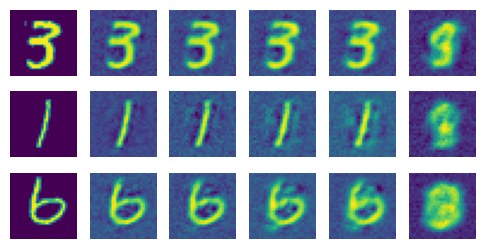

In [51]:
#@title Generate reconstructions

def generate_reconstructions(input_dim: int, output_dim: int, depth: int, variances: Tuple[float, float], lr: float = 1e-3):

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    print(f"Device: {device} with {torch.cuda.device_count()} gpus")

    torch.manual_seed(42)

    net = Network(input_dim=input_dim, output_dim=output_dim, depth=depth, variances = variances, device=device, size="wide")
    conet = ContraNetwork(net, device=device, lr=lr)

    train, test = get_train_data(bs=1024)

    conet.train(train)
    print("Losses: {}".format(conet.eval(test)))

    _, test = get_train_data(bs=3)
    features, _ = next(iter(test))
    reconstructions = conet.cascade(features)
    i_size, j_size, _ = np.array(reconstructions).shape
    #print(list(range(i_size)))
    #print(list(range(j_size)))

    test_fig = plt.figure(figsize=(i_size, j_size))
    for j in range(j_size):
        for i in range(i_size):
            test_fig.add_subplot(j_size, i_size, (i+1) + (i_size)*j)
            plt.axis("off")
            plt.imshow(reconstructions[i][j].reshape(28, 28))

generate_reconstructions(input_dim=28**2, output_dim=10, depth=5, variances=(1.76, 0.05), lr=0.004)

In [ ]:
#@title Train network (not sure I need this)

# necessary for cuda multiprocessing
mpl.set_start_method("spawn", force=True)

train_data, test_data = get_train_data(100)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

depth = 100
epochs = [0, 1, 10, 30, 50, 100, 200]
vars = [0.1, 1.6, 3.2]

for var_ in vars:
    print(f"START VAR = {var_} =======================================================================")
    # train network
    print("Start training forward net ----------------------------------------------------------")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(torch.cuda.mem_get_info(0))
    net = Network(28 ** 2, 10, depth, (var_, 0.05), device=device, size="shrinking")
    net.training(train_data, test_data, its=1)
    # for epoch in epochs:
    #    net = Network(28 ** 2, 10, depth, (var_, 0.05), device=device)
    #    loss, accs = net.training(train_data, test_data, epoch)
    #    _, acc = net.eval(test_data)
    #    print(f"Accuracy of {acc} reached for EPOCH = {epoch}")

    # handle conet
    # print("Start training co net ----------------------------------------------------------------")
    conet = ContraNetwork(net, device=device)

    td = conet.get_activations_sorted(train_data)
    ts = []
    for i in range(len(conet)):
        td_ = zip(td[i + 1], td[i])
        t1 = time.time()
        conet.train_lvl(i, td_)
        ts.append(time.time() - t1)
        print(f"{ts[-1]}")
    print(np.mean(ts), np.std(ts))

    #print(torch.cuda.mem_get_info(0))
    #t1 = time.time()
    #actis = conet.train_parallel_sequential(train_data, stop=20)
    #print(f"Time for Sequential: {time.time() - t1} s")

    #t1 = time.time()
    #actis = conet.train_queue(train_data)
    #print(f"Time for Queue: {time.time() - t1} s")

    # t1 = time.time()
    # activations = conet.get_activations_sorted(train_data)
    # print(f"Time for data collection: {time.time() - t1} s")

    # t1 = time.time()
    # conet.train_parallel(activations)
    # print(f"Time for Conet-training: {time.time() - t1} s")

    # plot reconstructions
    for inp, _ in test_data:
      cascades = conet.cascade(inp)
      for cascade in cascades:
          plt.imshow(cascade[0].reshape((28, 28)))
          plt.show()

In [9]:
#@title Entropy calculation


# https://math.stackexchange.com/questions/1804805/how-is-the-entropy-of-the-normal-distribution-derived
# https://de.wikipedia.org/wiki/Differentielle_Entropie
NORMALFACTOR = (0.5 * np.log(2 * np.pi * np.e))


def rel_entropy(first: torch.tensor, sec: torch.tensor, off: float = 1e-12) -> torch.tensor:
    """
    Calculate the relative entropy over two batches of activations
    :param first: torch.tensor = [batch, 1D activation]
    :param sec: torch.tensor = [batch, 1D activation]
    :param off: float = offset to apply to prevent zeros in first and sec
    :return: torch.tensor = [batch] relative entropy for each sample in batch
    """

    # ensure positive definiteness of tensors
    first -= torch.min(first, dim=1).values[:, None]
    sec -= torch.min(sec, dim=1).values[:, None]

    # prevent zero activation
    first += off
    sec += off

    # normalize
    first /= torch.sum(first, dim=1)[:, None]
    sec /= torch.sum(sec, dim=1)[:, None]

    # calculate relative entropy for x > 0, y > 0
    return torch.sum(first * torch.log(first / sec), dim=1)


def diff_entropy(actis: torch.tensor) -> torch.tensor:
    """
    Calculate the differential entropy between a set of activations
    :param actis: torch.tensor = [batch, activations]
    :return: float = differential entropy
    """
    # normalize
    actis /= torch.sum(actis, dim=1)[:, None]

    # get std
    std = torch.std(actis, dim=0)

    # calculate entropy
    return torch.mean(NORMALFACTOR + torch.log(std))


def cutoff_det(seq: torch.tensor, atol: float = 1e-8, rtol: float = 1e-5, method: str = "absolut") -> torch.tensor:
    """
    Search for saturation if seq with tolerance
    :param seq: torch.tensor = [batch, 1D entropy]
    :param atol: float = absolut tolerance when comparing floats
    :param rtol: float = relative tolerance when comparing floats
    :param method: str = method used to determine cutoff [absolut, differential]
    :return: torch.tensor = [batch] cutoffs for each run in batch
    """
    if method == "differential":
        gaussian = np.exp(-(np.linspace(-10, 10, 5) / 0.1) ** 2 / 2)
        #import matplotlib.pyplot as plt

        #plt.plot(seq[0])
        seq = [- np.diff(np.convolve(entropies, gaussian, mode="valid")) for entropies in seq]
        #plt.plot(seq[0])
        #plt.show()

    elif method != "absolut":
        raise ValueError(f"Method {method} unknown")

    cutoffs = torch.full((len(seq),), len(seq[0]), dtype=torch.int32, requires_grad=False)
    for i, entropies in enumerate(seq):
        reference = entropies[-1] if method == "absolut" else 0
        for j, entropy in enumerate(entropies[::-1]):
            if not (np.isclose(entropy, reference, atol=atol, rtol=rtol)):
                cutoffs[i] = len(entropies) - j - 1
                break
    return cutoffs

Device: cpu with 0 gpus
Training done in 13.091606140136719s
Cascade done in 0.04849505424499512s
17 100
Rel. entropy - Cutoff: 14.86 $ \pm $ 0.4025173313289777
Dif. entropy - Cutoff: [11]
Accuracy of 0.8696999996900558 reached
Training done in 13.560096979141235s


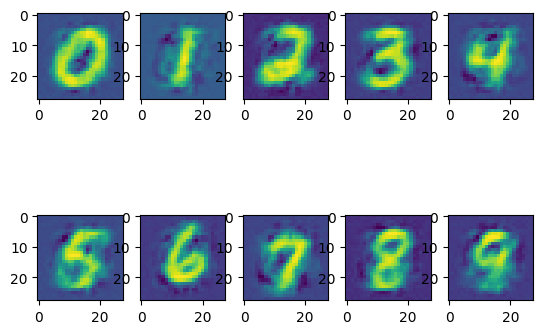

In [14]:
#@title Train single

# parameters for the network
DEPTH = 20
VARS = (1.65, 0.05)  # .9316000044345856
EPOCHS = 10

# load training data
train_data, test_data = get_train_data(bs=100)

# check for device to use
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device} with {torch.cuda.device_count()} gpus")

# initialize neural network
net = Network(28 ** 2, 10, DEPTH, VARS, device=device, size="shrinking")  # input should be 32**2 for CIFAR10 data
conet = ContraNetwork(net, device=device)

# train reconstruction
conet.train(train_data)

# show some reconstructions and determined cutoffs
for inp, _ in test_data:
    cascades = conet.cascade(inp)
    reference = cascades[0]

    # get cutoff from cascades with relative entropy
    entropies = [rel_entropy(reference, sec).tolist() for sec in cascades[1:-2]]
    print(len(entropies), len(entropies[0]))
    entropies = tuple(zip(*entropies))

    cutoffs = cutoff_det(entropies, rtol=0.01).tolist()
    print(f"Rel. entropy - Cutoff: {np.mean(cutoffs)} $ \\pm $ {np.std(cutoffs, ddof=1)}")

    # get cutoff from cascades with differential entropy
    entropies = [[diff_entropy(sec).tolist() for sec in cascades[1:-2]]]
    cutoffs = cutoff_det(entropies, rtol=0.01).tolist()
    print(f"Dif. entropy - Cutoff: {cutoffs}")
    break


# LETS HAVE SOME MORE FUN WITH RECONSTRUCTIONS
# train neural network
loss, accs = net.training(train_data, test_data, EPOCHS)
_, acc = net.eval(test_data)
print(f"Accuracy of {acc} reached")

# train reconstruction
conet.train(train_data)

# create inputs which would cause a maximal output for a specific class
fig, ax = plt.subplots(2, 5)
axs = ax.flatten()
for i in range(10):
    image = conet.get_perfect(i, full=-1.0)[0].reshape(28, 28)
    axs[i].imshow(image)
plt.show()

In [11]:
#@title Collect data

# parameters for the network
DEPTH = 200
VARS = np.arange(0.1, 4.0, 0.1)[::-1]
print(len(VARS))
print(VARS)

PATH = DATA_PATH / "collect_data"

if not PATH.exists():
    PATH.mkdir()

if not (PATH / "entropy").exists():
    (PATH / "entropy").mkdir()

if not (PATH / "data").exists():
    (PATH / "data").mkdir()

if not (PATH / "images").exists():
    (PATH / "images").mkdir()

# load training data
_, test_data = get_train_data(bs=100)
train_data, _ = get_train_data()


# check for device to use
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device} with {torch.cuda.device_count()} gpus")


for var_w in VARS:
    # initialize neural network
    net = Network(28 ** 2, 10, DEPTH, (var_w, 0.05), device=device, size="wide")  # input should be 32**2 for CIFAR10 data
    conet = ContraNetwork(net, device=device)

    # train reconstruction
    conet.train(train_data, its=1)

    # show some reconstructions and determined cutoffs
    for inp, _ in test_data:
        cascades = conet.cascade(inp)
        reference = cascades[0]

        # get cutoff from cascades with relative entropy
        entropies = [rel_entropy(reference, sec).tolist() for sec in cascades[1:-2]]
        entropies = np.array(tuple(zip(*entropies)))

        plt.title(f"{var_w}")
        plt.plot(np.average(entropies.transpose(), axis=1))
        plt.savefig(f"{PATH}/images/{var_w:.2f}.png")
        plt.close()

        # determine cutoff of average
        entropies_avg = entropies / entropies[:, -1][:, None]
        avg_entropies = np.median(entropies_avg.transpose(), axis=1).reshape([1, len(entropies[0])])
        rel_avg_cutoff = cutoff_det(avg_entropies, rtol=0.005)[0]
        print(f"Rel. Avg entropy - Cutoff: {rel_avg_cutoff}")

        # determine cutoff of single relative entropies
        cutoffs = cutoff_det(entropies, rtol=0.005).tolist()
        rel_cutoff = (np.mean(cutoffs), np.std(cutoffs, ddof=1))
        print(f"Rel. entropy - Cutoff: {rel_cutoff[0]} $ \\pm $ {rel_cutoff[1]}")

        # get cutoff from cascades with differential entropy
        entropies = [[diff_entropy(sec).tolist() for sec in cascades[1:-2]]]
        with open(f"{PATH}/entropy/diff_entropy_{var_w : .3f}.csv", "w") as doc:
            doc.writelines("\n".join([";".join([str(v) for v in e]) for e in entropies]))
        # plt.plot(entropies[0])
        # plt.show()
        # cutoff = cutoff_det(entropies, atol=5e-1, method="differential")[0]
        cutoff = cutoff_det(entropies, rtol=0.005)[0]
        print(f"Dif. entropy - Cutoff: {cutoff}")

        with open(f"{PATH}/data/entropy_{var_w : .3f}.csv", "w") as doc:
            doc.writelines([f"Rel. entropy; {rel_cutoff[0]}; {rel_cutoff[1]}\n",
                            f"Dif. entropy; {cutoff}\n",
                            f"R. A entropy; {rel_avg_cutoff}"])
        break

39
[3.9 3.8 3.7 3.6 3.5 3.4 3.3 3.2 3.1 3.  2.9 2.8 2.7 2.6 2.5 2.4 2.3 2.2
 2.1 2.  1.9 1.8 1.7 1.6 1.5 1.4 1.3 1.2 1.1 1.  0.9 0.8 0.7 0.6 0.5 0.4
 0.3 0.2 0.1]
Device: cuda with 1 gpus
Training done in 180.67620539665222s
Cascade done in 0.9552505016326904s
Rel. Avg entropy - Cutoff: 104
Rel. entropy - Cutoff: 154.17 $ \pm $ 21.535526204132765
Dif. entropy - Cutoff: 194
Training done in 181.43582606315613s
Cascade done in 0.9760541915893555s
Rel. Avg entropy - Cutoff: 131
Rel. entropy - Cutoff: 183.36 $ \pm $ 10.76049640250313
Dif. entropy - Cutoff: 194
Training done in 181.6497540473938s
Cascade done in 0.9759860038757324s
Rel. Avg entropy - Cutoff: 114
Rel. entropy - Cutoff: 153.97 $ \pm $ 21.663848301544284
Dif. entropy - Cutoff: 192
Training done in 182.11785531044006s
Cascade done in 0.9855053424835205s
Rel. Avg entropy - Cutoff: 115
Rel. entropy - Cutoff: 169.29 $ \pm $ 15.550046282694446
Dif. entropy - Cutoff: 195
Training done in 180.6329209804535s
Cascade done in 0.98959779

In [ ]:
#@title Collect falling

torch.backends.cudnn.benchmark = True


# parameter for data collection
STARTVAR = 1.7
VARRANGE = [0.1, 4.0]
DIRECTION = -1  # -1

ACCTHRESHOLD = 0.4
VARSTEP = 0.1
STARTDEPTH = 150
DEPTHSTEP = 5
EPOCHS = 200

PATH = DATA_PATH / "collect_falling"


# function for evaluation of network configuration
def evaluate(depth: int, var_: float, train_data, test_data, device: Union[torch.device, str] = "cpu") -> List[float]:
    """
    Train a network for a given variance var for the weights
    :param depth: int = number of layers of the network
    :param var: float = weight-variance for initialization
    :param device: Union[torch.device, str] = device to perform calculation on
    :return: List[float] = accuracy(epoch)
    """
    net = Network(32 ** 2, 10, depth, (var_, 0.05), device=device, size="shrinking")

    accs = []
    for i in range(EPOCHS):
        loss, accs_ = net.training(train_data, test_data, 1, verbose=False)
        accs.append(accs_[0])
        print(f"\rTraining {i + 1} / {EPOCHS} : {accs_[0]}", end="")
        if accs_[0] > ACCTHRESHOLD:
            break
    print("")
    with open(f"{PATH}/net_{var_}_{depth}.txt", "w") as doc:
        doc.writelines("\n".join([f"{i};{a}" for i, a in enumerate(accs)]))

    return accs


# create path to store information in
if os.path.exists(PATH):
    pass
    # raise AttributeError("Path exists!")
else:
    os.mkdir(PATH)

# load device to perform calculations on
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device} with {torch.cuda.device_count()} gpus")

# get training data
train_data, test_data = get_train_data_cifar(bs=64)

# configuration parameter

depth = STARTDEPTH
var_ = STARTVAR

while True:
    print(f"Train: {var_}")

    while True:
        acc = evaluate(depth, var_, train_data, test_data, device)[-1]
        if acc > ACCTHRESHOLD:
            break
        depth -= DEPTHSTEP
        print(f"Update left depth to: {depth}")
    var_ += DIRECTION * VARSTEP
    var_ = round(var_, 2)

    if not (VARRANGE[0] <= var_ <= VARRANGE[1]):
        break


Min: -19.39264488220215
Max: -6.312370300292969


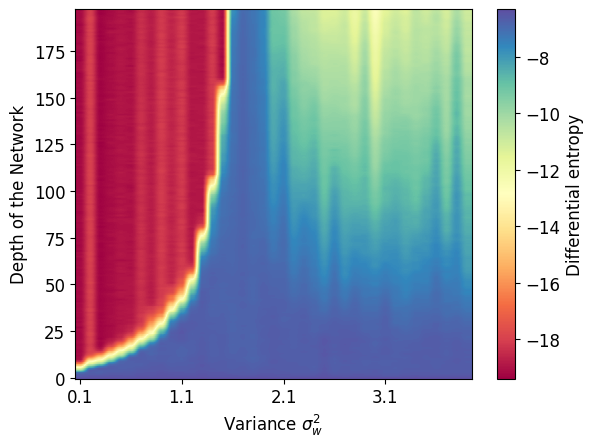

In [5]:
#@title Plot infos

PATH = DATA_PATH / "collect_data/entropy"

matplotlib.rcdefaults()
matplotlib.rc("font", **{"size": 12})

files = os.listdir(PATH)
table = []
for file in files:
    with open(f"{PATH}/{file}", "r") as doc:
        lines = doc.readlines()
    values = [float(v) for v in lines[0].split(";")]
    var_ = float(file.split("_")[-1][:-4])
    table.append((var_, values))

table.sort(key=lambda x: x[0])
vars_ = [t[0] for t in table]
table = np.array([t[1] for t in table])
table = np.rot90(table)
table = table[::-1]
print(f"Min: {np.min(table)}\nMax: {np.max(table)}")

im = plt.imshow(table, aspect="auto", origin='lower', cmap="Spectral")  # coolwarm, hot, bwr, seismic
cbar = plt.colorbar(im)
cbar.set_label("Differential entropy", rotation=90)
plt.xlabel("Variance $\\sigma_w^2$")
plt.ylabel("Depth of the Network")
plt.xticks(list(range(len(vars_)))[::10], vars_[::10])
#plt.grid()
plt.show()

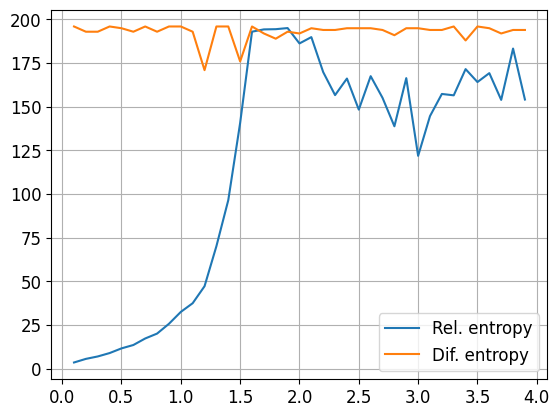

In [21]:
#@title Plot data

#PATH = "data_120" ??
PATH = DATA_PATH / "collect_data/data"

files = os.listdir(PATH)
files.sort(key=lambda x: float(x.split("_")[1][:-4]))

xs = []
rel_entropies = []
dif_entropies = []
for file in files:
    with open(f"{PATH}/{file}", "r") as doc:
        lines = doc.readlines()
    xs.append(float(file.split("_")[1][:-4]))
    rel_entropies.append(float(lines[0].split(";")[1]))
    dif_entropies.append(int(lines[1].split(";")[1]))

plt.plot(xs, rel_entropies, label="Rel. entropy")
plt.plot(xs, dif_entropies, label="Dif. entropy")
plt.grid()
plt.legend()
plt.show()

In [ ]:
#@title Plot falling

matplotlib.rc("font", **{"size": 22})


def plot_theoretic():
    with open("../theoretic_curve.txt", "rb") as doc:
        xis, test_w = pickle.load(doc)
    plt.plot(test_w, xis, "-", label="$\\xi_c$ - Mean field prediction", color="black")
    plt.plot(test_w, 6 * xis, "--", label="$6\\xi_c$  - Mean field prediction", color="black")


path = "data/collect_falling"
path2s = ["data/collect_data/data"]


files = os.listdir(path)
nets = [file for file in files if not "conet" in file]

# get only most shallow net and conet for each variance
nets_selected = {}
for net in nets:
    var = float(net.split("_")[1])
    depth = int(net.split("_")[2][:-4])
    if not (var in nets_selected):
        nets_selected[var] = (depth, net)
    elif nets_selected[var][0] > depth:
        nets_selected[var] = (depth, net)
nets = nets_selected


# plot the accuracy
norm = matplotlib.colors.Normalize(vmin=0.1, vmax=0.4)  # 0.43
cmap = matplotlib.cm.get_cmap("viridis")

# get accuracy
for key in nets:

    with open(f"{path}/{nets[key][1]}", "r") as doc:
        infos = doc.readlines()
    infos = [info.replace("\n", "") for info in infos]
    infos = [float(info.split(";")[1]) for info in infos]
    acc = max(infos)

    # plot bar with accuracy, transparent and depth
    # plot bar on top with 0.1 accuracy, transparent
    plt.bar(float(key), 200, width=0.1, color=cmap(norm(0.1)), alpha=0.6)
    plt.bar(float(key), nets[key][0], width=0.1, color=cmap(norm(acc)), alpha=0.6)



# get all cutoffs
for path2 in path2s:
    cutoffs = [[], [], []]
    conets = [file for file in os.listdir(path2)]
    for conet in conets:
        with open(f"{path2}/{conet}", "r") as doc:
            lines = doc.readlines()

        key = float(conet.split("_")[1][:-4])
        for i, line in enumerate(lines):
            print(f"{i}: {line}")
            depth = line.replace("\n", "").split(";")[1]
            cutoffs[i].append((key, float(depth)))

    # plot all cutoffs
    for index, entropy_type in zip(range(3), cutoffs):
        if not (index in [2]):  # [rel_entropy, diff_entropy, avg_rel_entropy] if [2] only plots avg_rel_entropy
            continue
        entropy_type.sort(key=lambda x: x[0])
        xs, ys = tuple(zip(*entropy_type))
        plt.plot(xs, ys, "x-", lw=2.0, label="Relative Entropy cutoff")

cbar = plt.colorbar(mappable=cm.ScalarMappable(norm=norm, cmap=cmap), ax=plt.gca(), alpha=0.6)
cbar.set_label("Accuracy", rotation=90)
#plot_theoretic()
plt.legend(loc="lower right")
plt.xlabel("Variance $\\sigma_w^2$")
plt.ylabel("Depth of the Network")
plt.ylim((1, 150))
plt.xlim((0.8, 4.0))
plt.show()
